# Golden Cross / Death Cross S&P 500 index (^GSPC)

    1. sma50>sma200, buy
    2. sma50<sma200, sell your long position.

In [1]:
import datetime

import matplotlib.pyplot as plt
import pandas as pd
from talib.abstract import *

import pinkfish as pf

# Format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# Set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Some global data

In [3]:
symbol = '^GSPC'
#symbol = 'SPY'
capital = 10000
start = datetime.datetime(1900, 1, 1)
#start = datetime.datetime(*pf.SP500_BEGIN)
end = datetime.datetime.now()

use_adj=True

Prepare timeseries

In [4]:
# Fetch and select timeseries.
ts = pf.fetch_timeseries(symbol,)
ts = pf.select_tradeperiod(ts, start, end, use_adj=use_adj)

# Add technical indicator: day sma regime filter.
ts['regime'] = \
    pf.CROSSOVER(ts, timeperiod_fast=50, timeperiod_slow=200)

# Finalize the time series before implementing trading strategy.
ts, start = pf.finalize_timeseries(ts, start)

# Create Trade Log (tlog); Create Daily Balance (dbal).
tlog = pf.TradeLog(symbol)
dbal = pf.DailyBal()

Algo: Buy when 50 day ma crosses above 200 day ma.  Sell when 50 day ma crosses below 200 day ma. 

In [5]:
pf.TradeLog.cash = capital

for i, row in enumerate(ts.itertuples()):

    date = row.Index.to_pydatetime()
    high = row.high; low = row.low; close = row.close; 
    end_flag = pf.is_last_row(ts, i)

    # Buy
    # Note ts['regime'][i-1] is regime for previous day
    # We want to buy only on the day of a moving average crossover
    # i.e. yesteraday regime is negative, today it is positive
    if tlog.shares == 0:
        if row.regime > 0 and ts['regime'][i-1] < 0:
            tlog.buy(date, close)  
    # Sell
    else:
        if row.regime < 0 or end_flag:
            tlog.sell(date, close)

    # record daily balance
    dbal.append(date, high, low, close)       

Retrieve logs

In [6]:
tlog = tlog.get_log()
dbal = dbal.get_log(tlog)

Generate strategy stats - display all available stats

In [7]:
stats = pf.stats(ts, tlog, dbal, capital)
pf.print_full(stats)

start                                                  1928-10-16
end                                                    2020-10-16
beginning_balance                                           10000
ending_balance                                         2392098.42
total_net_profit                                       2382098.42
gross_profit                                           2736959.76
gross_loss                                             -354861.34
profit_factor                                                7.71
return_on_initial_capital                                23820.98
annual_return_rate                                           6.13
trading_period                           92 years 0 months 0 days
pct_time_in_market                                          65.96
margin                                                          1
avg_leverage                                                 1.00
max_leverage                                                 1.00
min_levera

Benchmark: Run, retrieve logs, generate stats

In [8]:
benchmark = pf.Benchmark(symbol, capital, start, end, use_adj=use_adj)
benchmark.run()

Plot Equity Curves: Strategy vs Benchmark

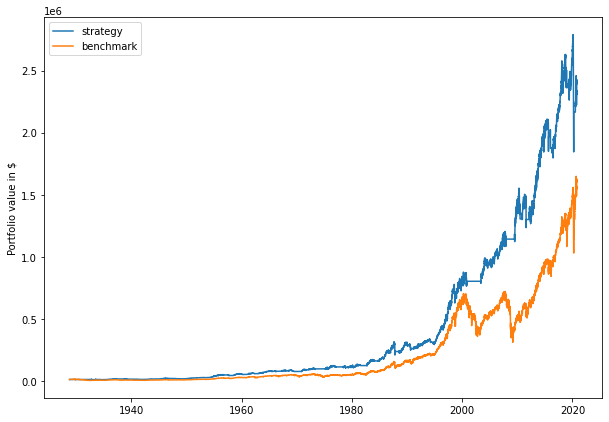

In [9]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

Plot Trades

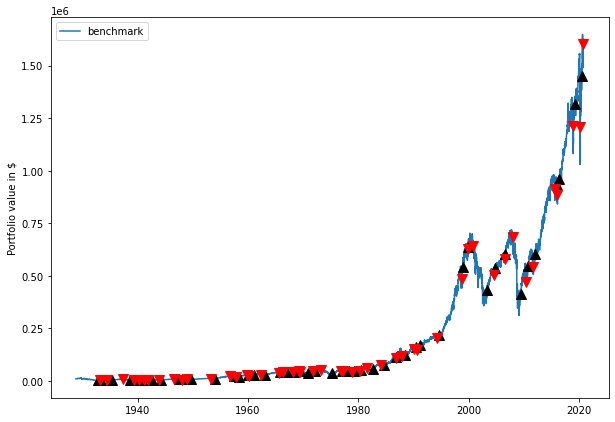

In [10]:
pf.plot_trades(dbal, benchmark=benchmark.dbal)

Strategy vs Benchmark

In [11]:
df = pf.summary(stats, benchmark.stats, metrics=pf.currency_metrics)
df

,strategy,benchmark
beginning_balance,"$10,000.00","$10,000.00"
ending_balance,"$2,392,098.42","$1,602,561.43"
total_net_profit,"$2,382,098.42","$1,592,561.43"
gross_profit,"$2,736,959.76","$1,592,561.43"
gross_loss,"-$354,861.34",$0.00


,strategy,benchmark
annual_return_rate,6.13,5.67
max_closed_out_drawdown,-36.86,-86.14
annualized_return_over_max_drawdown,0.17,0.07
best_month,22.49,61.27
worst_month,-30.91,-42.17
sharpe_ratio,0.53,0.39
sortino_ratio,0.52,0.48
monthly_std,3.29,5.35
annual_std,12.95,19.92
avg_month,0.53,0.58


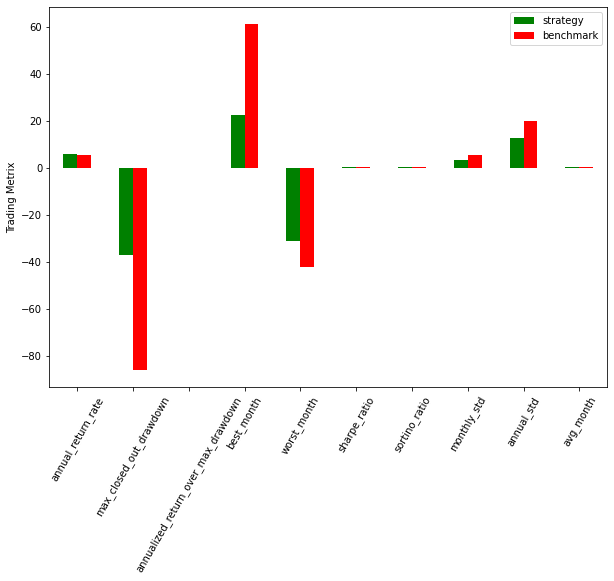

In [12]:
extras = ('avg_month',)

df = pf.plot_bar_graph(stats, benchmark.stats, extras=extras)
df